# 1. Imports and constants

!!! For replicating a Conda Virtual environment has to be installed first. Follow the installation guide in README.md file

In [1]:
import os
# solves GPU memory allocation while using 2 LLMs
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".40"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

import cv2
from glob import glob
from os.path import basename

import numpy as np
import pandas as pd
import base64

import tensorflow as tf
import torch

from IPython.display import Video
from IPython.display import display, Image, HTML

import chatgpt as gpt
import Classifier as mn
import VideoCutter as vc

import paligemma as pg
import florence as fl


tf.get_logger().setLevel('ERROR')
os.environ['CUDA_DEVICE_QUIET']='1'

video_path='./assets/video.mp4'
repr_path='./assets/representations/' # path where the most distinctive representations of facilites will be extracted and stored

# function for future VLLM use
def prep_test_df():
    files = [(basename(x).split('_')[0], x) for x in glob(repr_path + '/*.jpg')]
    df = pd.DataFrame(files, columns=['class', 'file_name'])
    df=pd.merge(df, gpt.QUESTIONS, on='class')
    df['gpt_reply']=''
    return df

2024-08-20 13:13:50.577128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 13:13:50.587017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 13:13:50.595797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 13:13:50.598397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 13:13:50.605038: I tensorflow/core/platform/cpu_feature_guar

[CudaDevice(id=0)]
JAX backend: gpu
JAX version:  0.4.31
JAX platform: gpu
JAX devices:  1


I0000 00:00:1724123633.787741    9342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-20 13:13:53.788683: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Download sample video and models' weights, prepare assets structure

In [2]:
!rm -r ./assets
!mkdir ./assets
!mkdir ./assets/results
!mkdir ./assets/representations
!mkdir ./assets/models
!mkdir ./assets/models/yolo
!mkdir ./assets/models/cls
!mkdir ./assets/models/paligemma
!mkdir ./assets/models/florence2

!wget -O {video_path} 'https://www.dropbox.com/scl/fi/6t0hiqqkbqik8imx9mj8b/Video3080_10May2024.mp4?rlkey=h154to87uaubx12mq7cz8mclk&st=063fphda&dl=0'

# Yolo downloader
!wget -O ./assets/models/yolo/yolo_weights.pt 'https://www.dropbox.com/scl/fi/5itaoe36ib3ykyddtvszc/yolo_weights.pt?rlkey=3957aet95hw89gx8tslh7h2jp&st=ri261hjy&dl=0'

# Feature extractor downloader 
!wget -O ./assets/models/cls.tar.gz 'https://www.dropbox.com/scl/fi/55sk5hbniay5bxhzlm8qn/cls.tar.gz?rlkey=2orczp470op6mc1vf1iho03g1&st=i42wbqlc&dl=0'
!tar -xvzf ./assets/models/cls.tar.gz -C ./assets/models/cls/
!rm ./assets/models/cls.tar.gz

# VLM_1 - Florence-2 downloader
!wget -O ./assets/models/florence2.tar.gz 'https://www.dropbox.com/scl/fi/6a8oyw1ej9zyiji09pysr/florence2.tar.gz?rlkey=urnbfn81os24k4m6a51701l3i&st=8t6gixg3&dl=0'
!tar -xvzf ./assets/models/florence2.tar.gz -C ./assets/models/florence2/
!rm ./assets/models/florence2.tar.gz

# VLM_1 - Paligemma downloader
!wget -O ./assets/models/paligemma/paligemma.npz 'https://www.dropbox.com/scl/fi/gv86ozaeexqs9tbkkl1at/paligemma.npz?rlkey=wfl7ghuagqqc3xao0etksxip4&st=gskflobo&dl=0'
!wget -O ./assets/models/paligemma/pg_tokenizer.model 'https://www.dropbox.com/scl/fi/oizj796tv9ot4m2lytcgo/pg_tokenizer.model?rlkey=nv6n0i3iuijgdzczzfz5hbm5q&st=tk41lewh&dl=0'


/ML/Common/envs/sfood/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rm: cannot remove './assets': Directory not empty
mkdir: cannot create directory ‘./assets’: File exists
--2024-08-20 13:14:02--  https://www.dropbox.com/scl/fi/6t0hiqqkbqik8imx9mj8b/Video3080_10May2024.mp4?rlkey=h154to87uaubx12mq7cz8mclk&st=063fphda&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.83.18, 2620:100:6033:18::a27d:5312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.83.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca902e198c078954fdbc98e9412.dl.dropboxusercontent.com/cd/0/inline/CY_aCui1Sj9hmkAXHaJRfgStCJkPoRlGNUf-vDWmgTb84PWNDLF1IXzwXs_QWHsGsNGWe33qdGP1GfaUFXu8HGdP1_v1Q1EWifzIOI1vn_hY4QTf8C5ZHIn_coUs80NALBk/file# [following]
--2024-08-20 13:14:03--  https://uca902e198c078954fdbc98e9412.dl.dropboxusercontent.com/cd/0/inline/CY_aCui1Sj9hmkAXHaJRfgStCJkPoRlGNUf-vDWmgTb84PWNDLF1IXzwXs_QWHsGsNGWe33qdGP1GfaUFXu8HGdP1_v1Q1EWifzIOI1vn_hY4QTf8C5ZHIn_coUs80NALBk/file
Resolving uca902e198c078954fdbc98e9412.dl.dropboxus

## Let us watch the survey video

In [3]:
if not os.path.exists(video_path):
    !wget -O {video_path} 'https://www.dropbox.com/scl/fi/6t0hiqqkbqik8imx9mj8b/Video3080_10May2024.mp4?rlkey=h154to87uaubx12mq7cz8mclk&st=063fphda&dl=0'
    
from IPython.display import HTML
HTML(f"""
<video width="640" height="480" controls>
  <source src="{video_path}" type="video/mp4">
</video>
""")

# 2. Extract unique representations of each facility we assess from the video feed

In [4]:
os.makedirs(repr_path,exist_ok=True)
reprs=vc.cutVideo(video_path, output_path=repr_path)

/ML/ML/Code/Python/Projects/Submissions/StreetFood/ultralytics/nn/tasks.py:729: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
/ML

25.506982564926147


2024-08-20 13:48:33.679235: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
2.5407803058624268


### Now, let us examine the most distinctive representations that were extracted from the video:

DW



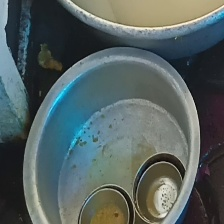
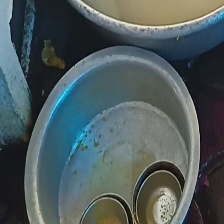
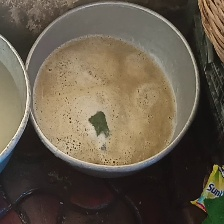
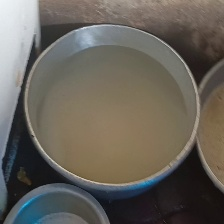
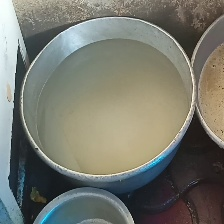

GB



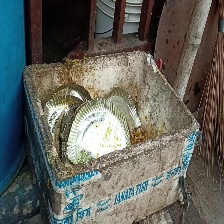
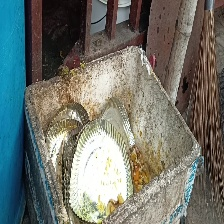
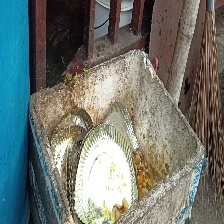
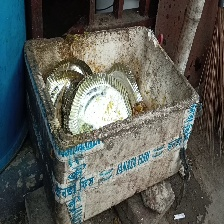
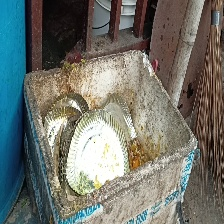

WP



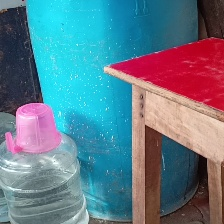
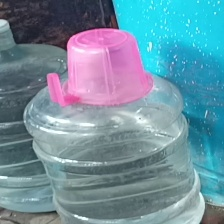
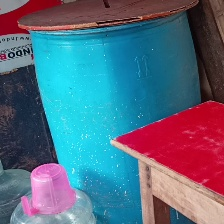
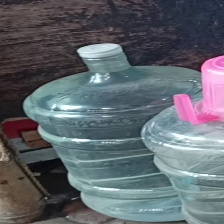
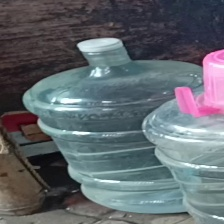

In [6]:
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

def display_reprs(image_paths):
    image_html = ''.join([f'<img src="data:image/png;base64,{image_to_base64(img)}" style="display:inline-block; margin-right:10px; width:200px;">' for img in image_paths])
    display(HTML(image_html))


files = [(basename(x).split('_')[0],x) for x in glob(repr_path+'/*.jpg')]
df=pd.DataFrame(files,columns=['class','file_name'])
dfg=df.groupby(by='class')
for g,gr in dfg:
    print(g)
    display_reprs(gr['file_name'].values)

#### As we can see, the pipeline chose unique objects: each individual Dishwasher boul, and each watertank is captured, as well as handwashing station and garbage bin. All the images extracted are clear (no motion blur), and we also get various perspectives (angles) of the objects for deep analysis.

# 3. VLLM analysis


## Display results functions

In [7]:
import utils
import io

from IPython.display import HTML, display
def display_image_and_text(image_path, text):
    with open(image_path, "rb") as img_file:
        image_base64 = base64.b64encode(img_file.read()).decode('utf-8')

    formatted_text = text.replace("\n", "<br>")
    
    html_code = f"""
    <div style="display: flex; align-items: center;">
        <div style="flex: 1;">
            <img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">
        </div>
        <div style="flex: 1; padding-left: 20px;">
            <p style="font-size: 14px;">{formatted_text}</p>
        </div>
    </div>
    """
    
    display(HTML(html_code))

def load_and_display_results(file_name):
    df=pd.read_csv(f'./assets/results/{file_name}')
    df=df.sort_values(by=['file_name','dcode'])
    dfg=df.groupby(by='file_name')
    for file_path,gr in dfg:
        text=''
        for i in range(gr.shape[0]):
            row=gr.iloc[i,:]
            dcode=row['dcode']
            question=gpt.QUESTIONS[gpt.QUESTIONS['dcode']==dcode]['question'].values[0]
    
            text+=question+'\n -'+row['reply']+'\n'+'\n'
        display_image_and_text(repr_path+file_path, text)

## Paligemma inference

In [9]:
pg.create_food_safety_dataset(val_df=prep_test_df())
mod_name='paligemma'
pg.prepare_model(mod_name)
preds=pg.food_safety_predictions()
preds['short_answer']=[gpt.extract_short_answer(x) for ii,x in enumerate(preds['reply'])]
preds.to_csv('./assets/results/paligemma.csv',index=None)
pg.clear_memory()


done
 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float32
img/Transformer/encoder_norm/scale                                               (1152,)                float32
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float32
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float32
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float32
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                          

2024-08-20 13:50:38.401475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Paligemma prediction. Time taken: 19.510263204574585



### Show Paligemma's results


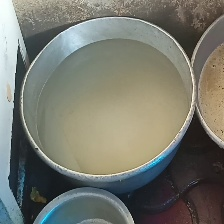


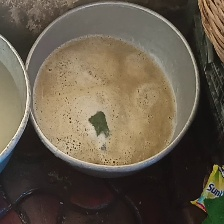


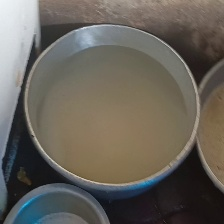


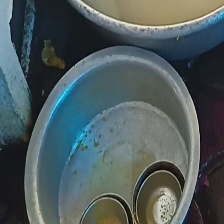


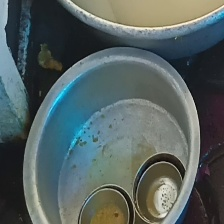


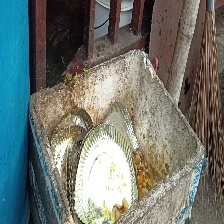


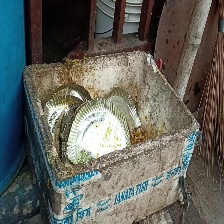


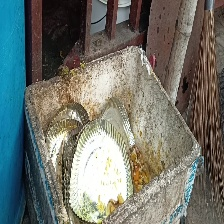


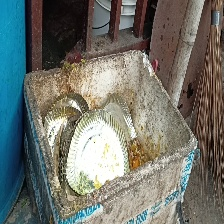


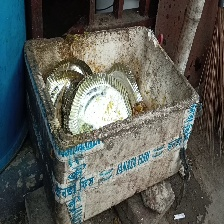


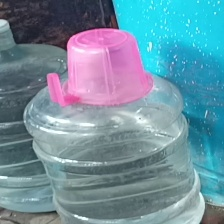


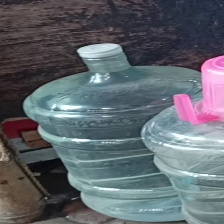


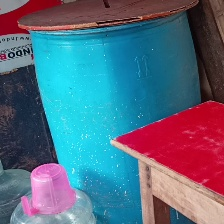


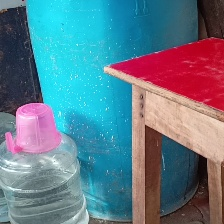


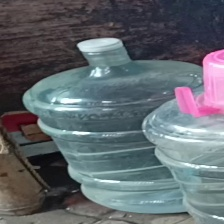

In [10]:
load_and_display_results('paligemma.csv')

## Florence-2 inference

In [11]:
preds=fl.predict_dataframe(prep_test_df())
preds.to_csv('./assets/results/florence2.csv',index=None)
torch.cuda.empty_cache()

Florence2 prediction time: 4.179263114929199


### Show Florence-2 results


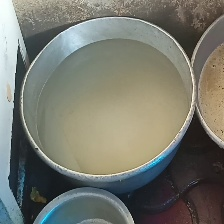


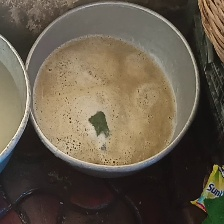


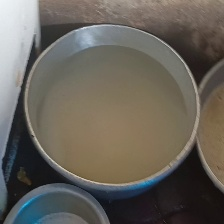


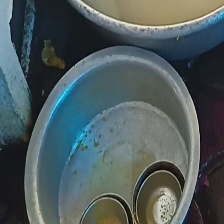


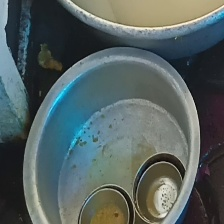


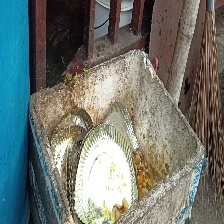


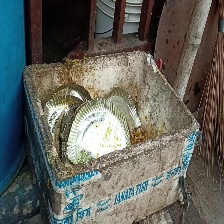


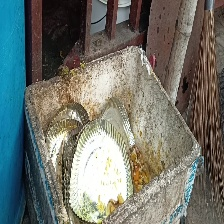


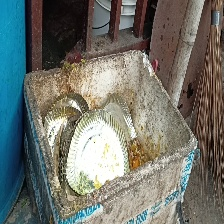


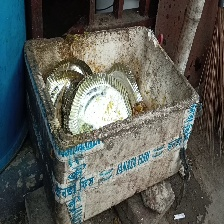


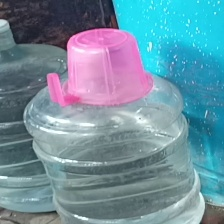


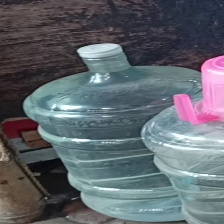


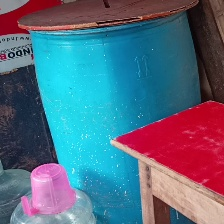


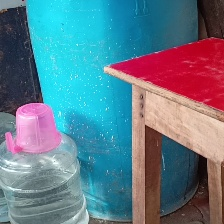


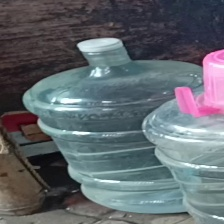

In [12]:
load_and_display_results('florence2.csv')